# SED Processing Testing V2
This is an extension of the previous notebook which tests the functions that have been developed for processing and creating composite SEDS
The ides is that these functions will be useable enough, and will be flexible enough to allow for resuseability with different SEDs and with different AGN models

In [413]:
# Import in all of the required libraries
import matplotlib.pyplot as plt
import astropy.units as u
import numpy as np
import pandas as pd
import os
from astLib import astSED
import astropy.io.fits as fits
from carf import * # custom module for functions relating to the project

# So that we can change the helper functions without reloading the kernel
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [414]:
# setup all the directories we are getting our data from 

# Skirtor models
skirtor_folderpath = os.path.join('datasets', 'Templates', 'Skirtor')

# Swire templates
swire_folderpath = os.path.join('datasets', 'Templates', 'SWIRE')

# Brown templates
brown_folderpath = os.path.join('datasets', 'Templates', 'Brown', '2014','Rest')

# Filters
pb_U_path = os.path.join('datasets', 'Filters', 'Generic_Johnson.U.dat')
pb_V_path = os.path.join('datasets', 'Filters', 'Generic_Johnson.V.dat')
pb_J_path = os.path.join('datasets', 'Filters', '2MASS_2MASS.J.dat')

In [415]:
# In addition also use astSED to create filters
pb_U = astSED.Passband(pb_U_path, normalise=False)
pb_V = astSED.Passband(pb_V_path, normalise=False)
pb_J = astSED.Passband(pb_J_path, normalise=False)

# SWIRE + Skirtor Composite SEDs
This part of the document aims to test the combining proccess of the Skirtor AGN models, with the SWIRE templates. These templates have a shortened wavelength range so the functionality in the helper package should make sure these are both compatible and allow for composite seds to be made.


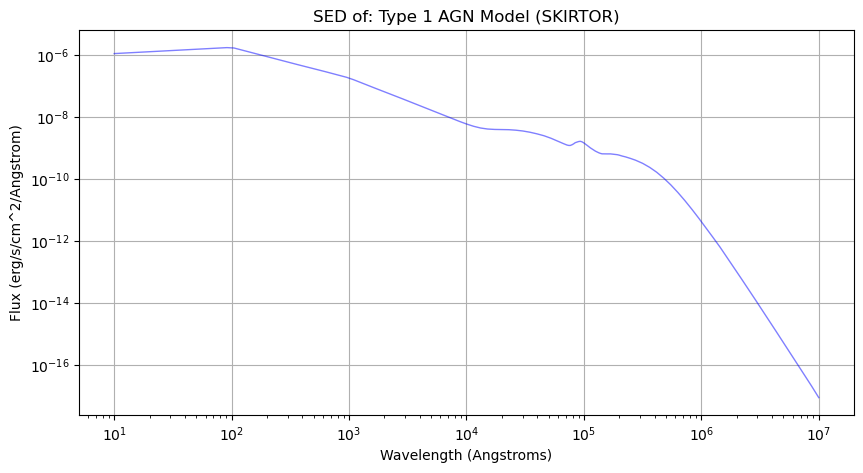

In [416]:
# Begin by attempting to create a composite of just 1 model
# For this we will define a type 1 agn model using the appropriate Skirtor parameters
# Begin by importing the first AGN model we would like to use
# 1. Type 1 AGN
tau = SKIRTOR_PARAMS['tau'][3]
p = SKIRTOR_PARAMS['p'][0]
q = SKIRTOR_PARAMS['q'][0]
oa = SKIRTOR_PARAMS['oa'][4]
rr = SKIRTOR_PARAMS['rr'][2]
i = SKIRTOR_PARAMS['i'][0]

agn_model = read_skirtor_model(skirtor_folderpath, tau, p, q, oa, rr, i)
wl_agn = agn_model['lambda (Angstroms)']
fl_agn = agn_model['Total Flux (erg/s/cm^2/Angstrom)']

# plot the agn model
plot_galaxy_sed(wl_agn, fl_agn, "Type 1 AGN Model", "SKIRTOR")

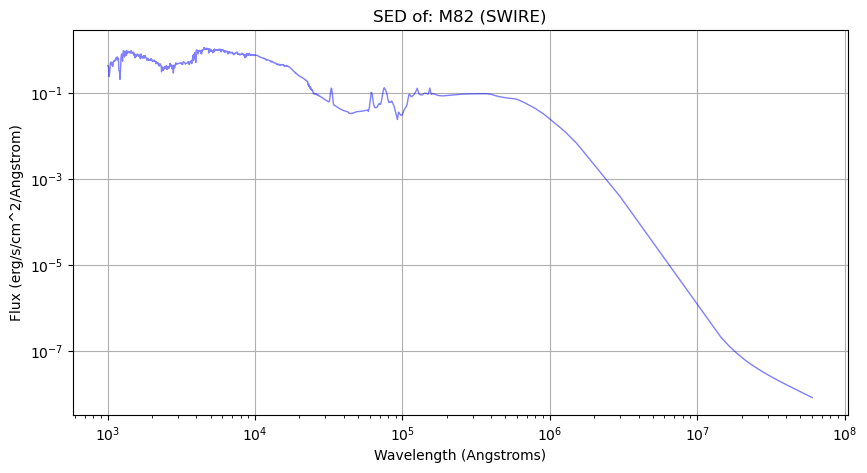

In [417]:
# Similarly we can plot a single swire template, we will use M82
m82_template, objname = read_swire_template(swire_folderpath, 'M82')
m82_template


wl_m82 = m82_template['lambda (Angstroms)']
fl_m82 = m82_template['Total Flux (erg/s/cm^2/Angstrom)']

# Plot the SED of M82
plot_galaxy_sed(wl_m82, fl_m82, 'M82', 'SWIRE')

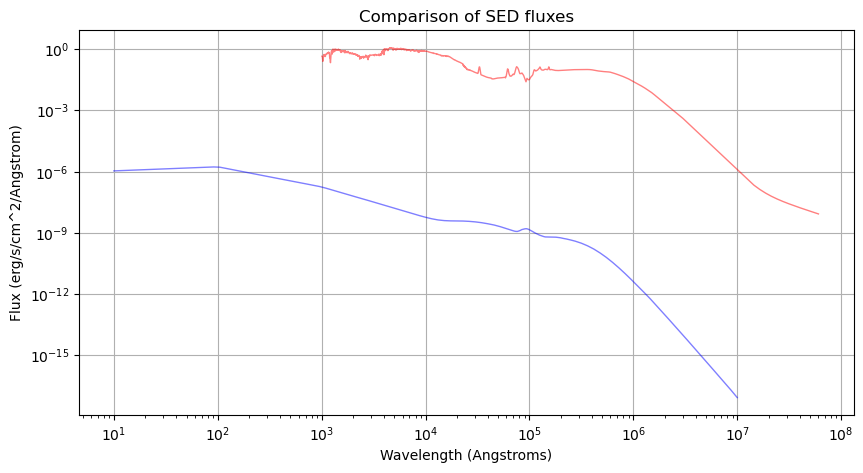

In [418]:
plt.figure(figsize=(10, 5))
plt.loglog(wl_m82, fl_m82, color='red', linewidth=1, linestyle='-', alpha=0.5)
plt.loglog(wl_agn, fl_agn, color='blue', linewidth=1, linestyle='-', alpha=0.5)
plt.xlabel('Wavelength (Angstroms)')
plt.ylabel('Flux (erg/s/cm^2/Angstrom)')
plt.title('Comparison of SED fluxes')
plt.grid()
plt.show()

From the graph above it is obvious that we can se that both of these SEDs don't exactly align in a way that will make sense or work for us. To rectify this we need to make sure that both of these SEDs exsist over the same wavelength range (are interpolated over a set of combined wavelengths, and are also within the same range of values. We see that the AGN has a lot more values in the shorter wavelength range, so for this to work this information must be cut off. This may be a limitation in the SWIRE templates but further investigation is needed. Our step now is to correct the wavelength range for these two SEDS

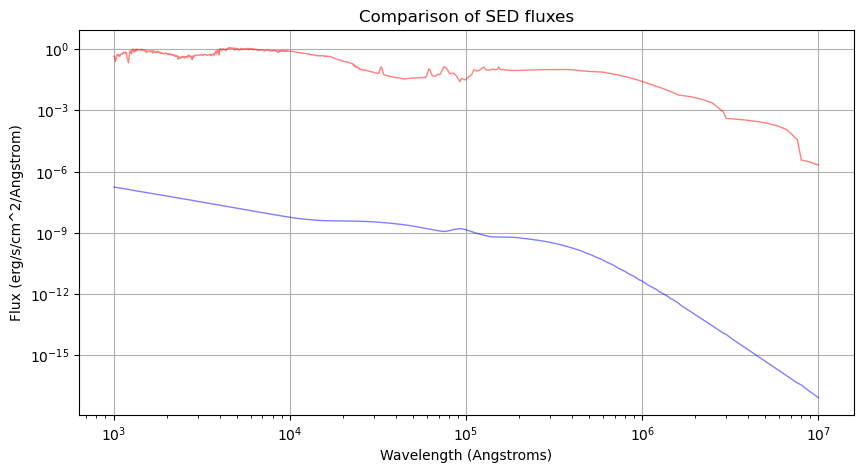

In [419]:
# We use our function two change the wavelenth range of the two SEDs, rectifying any missing wavelength values
m82_template, agn_model = adjust_wavelength_range(m82_template, agn_model)

# We can now attempt to replot these both on the same graph
wl_m82 = m82_template['lambda (Angstroms)']
fl_m82 = m82_template['Total Flux (erg/s/cm^2/Angstrom)']
wl_agn = agn_model['lambda (Angstroms)']
fl_agn = agn_model['Total Flux (erg/s/cm^2/Angstrom)']


# Plotting the adjusted SEDS
plt.figure(figsize=(10, 5))
plt.loglog(wl_m82, fl_m82, color='red', linewidth=1, linestyle='-', alpha=0.5)
plt.loglog(wl_agn, fl_agn, color='blue', linewidth=1, linestyle='-', alpha=0.5)
plt.xlabel('Wavelength (Angstroms)')
plt.ylabel('Flux (erg/s/cm^2/Angstrom)')
plt.title('Comparison of SED fluxes')
plt.grid()
plt.show()

We can see that this has correctly put the SEDs into the same wavelength range and in addition to this have made both of the SEDs compareable in the wavelength range. Now we need to make sure that we get the fluxes to be comparable. We do this by integrating the fluxes across the wavelength range, and then perform a normalization based on the integral of the flux.

In [420]:
# We now perform integral normalization on both of the SEDS
agn_model = normalize_flux_integral(agn_model)
m82_template = normalize_flux_integral(m82_template)



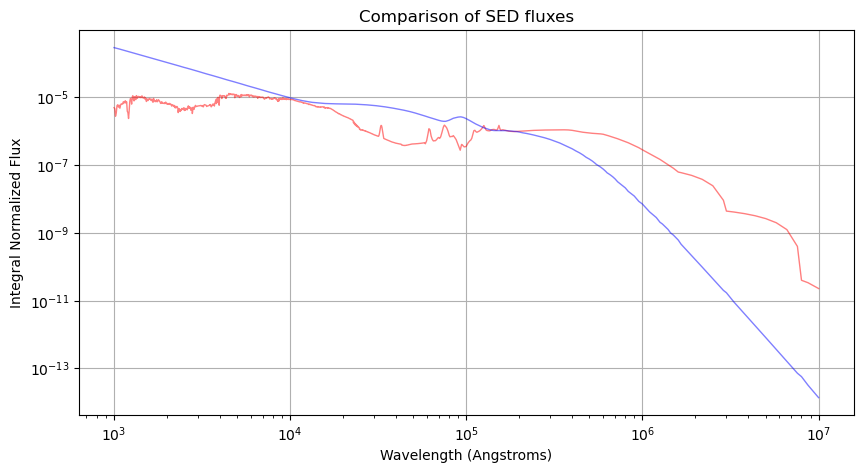

In [421]:
# We can attempt to plot these again 

# We can now attempt to replot these both on the same graph
wl_m82 = m82_template['lambda (Angstroms)']
fl_m82 = m82_template['integral normalized flux']
wl_agn = agn_model['lambda (Angstroms)']
fl_agn = agn_model['integral normalized flux']


# Plotting the adjusted SEDS
plt.figure(figsize=(10, 5))
plt.loglog(wl_m82, fl_m82, color='red', linewidth=1, linestyle='-', alpha=0.5)
plt.loglog(wl_agn, fl_agn, color='blue', linewidth=1, linestyle='-', alpha=0.5)
plt.xlabel('Wavelength (Angstroms)')
plt.ylabel('Integral Normalized Flux')
plt.title('Comparison of SED fluxes')
plt.grid()
plt.show()

In [422]:
# Now that we have a galaxy and a AGN which have integral normalized flux units, we can use our code to create composite agn+galaxies
# We begin with the example above

# Create an entirely new composite galaxy() with params alpha = 0.5, beta is default to 1, but set to (1-alpha for this)
# thus this is an galaxy composite created through sed addition: 50% AGN, 50% M82 (Starburst)
alpha = 0.5
agn_starburst_composite = create_gal_agn_composite_sed(agn_model, m82_template, alpha, (1-alpha))


agn_starburst_composite


,lambda (Angstroms),Total Flux (erg/s/cm^2/Angstrom)
0,1005.00,13.070191
1,1015.00,12.897069
2,1025.00,12.654373
3,1035.00,12.525509
4,1045.00,12.464833
...,...,...
1291,6606934.48,0.000057
1292,7585775.75,0.000018
1293,8000000.00,0.000002
1294,8709635.90,0.000002


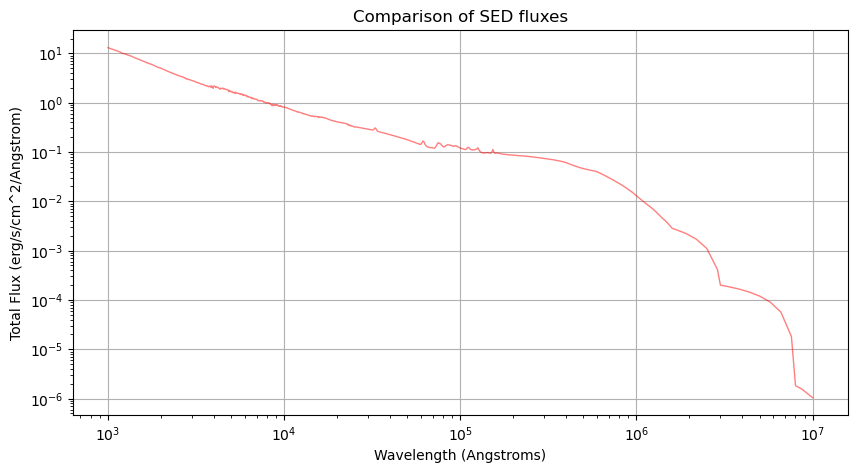

In [423]:
# We can now plot this composite
wl_comp = agn_starburst_composite['lambda (Angstroms)']
fl_comp = agn_starburst_composite['Total Flux (erg/s/cm^2/Angstrom)']


# Plotting the adjusted SEDS
plt.figure(figsize=(10, 5))
plt.loglog(wl_comp, fl_comp, color='red', linewidth=1, linestyle='-', alpha=0.5)
plt.xlabel('Wavelength (Angstroms)')
plt.ylabel('Total Flux (erg/s/cm^2/Angstrom)')
plt.title('Comparison of SED fluxes')
plt.grid()
plt.show()

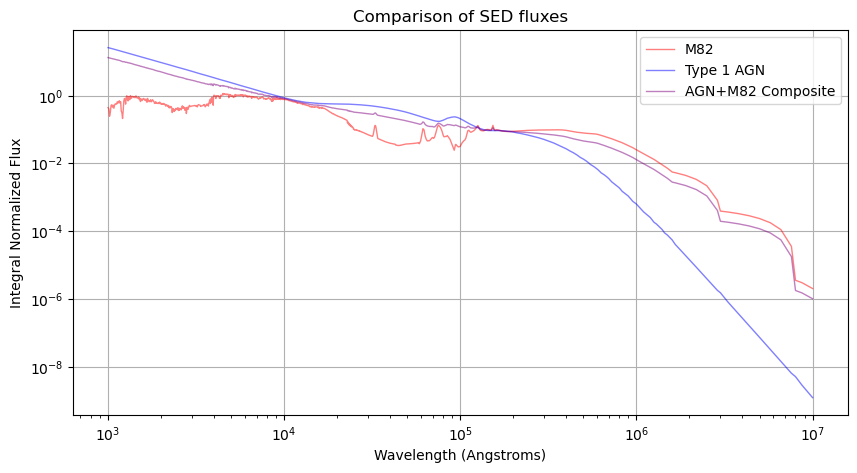

In [424]:
# Plotting this with it's component AGN bits
# We can now attempt to replot these both on the same graph
wl_m82 = m82_template['lambda (Angstroms)']
fl_m82 = m82_template['Total Flux (erg/s/cm^2/Angstrom)']
wl_agn = agn_model['lambda (Angstroms)']
fl_agn = agn_model['Total Flux (erg/s/cm^2/Angstrom)']


# Plotting the adjusted SEDS
plt.figure(figsize=(10, 5))
plt.loglog(wl_m82, fl_m82, color='red', linewidth=1, linestyle='-', alpha=0.5, label='M82')
plt.loglog(wl_agn, fl_agn, color='blue', linewidth=1, linestyle='-', alpha=0.5, label='Type 1 AGN')
plt.loglog(wl_comp, fl_comp, color='purple', linewidth=1, linestyle='-', alpha=0.5, label='AGN+M82 Composite')
plt.xlabel('Wavelength (Angstroms)')
plt.ylabel('Integral Normalized Flux')
plt.title('Comparison of SED fluxes')
plt.grid()
plt.legend()
plt.show()

In [425]:
# Now we see exactly how these work we also note that this is not what we want
# We again try but instead we use a scaling factor derived from the galaxy to determine how to scale the AGN


# We attempt this using the parameters alpha = 0.5, beta = 1
# where the scaling is done internally in the function
alpha = 0.5
agn_starburst_composite_add = create_gal_agn_composite_sed(agn_model, m82_template, alpha)
agn_starburst_composite_add

,lambda (Angstroms),Total Flux (erg/s/cm^2/Angstrom)
0,1005.00,13.289631
1,1015.00,13.103019
2,1025.00,12.777259
3,1035.00,12.679163
4,1045.00,12.717443
...,...,...
1291,6606934.48,0.000113
1292,7585775.75,0.000036
1293,8000000.00,0.000004
1294,8709635.90,0.000003


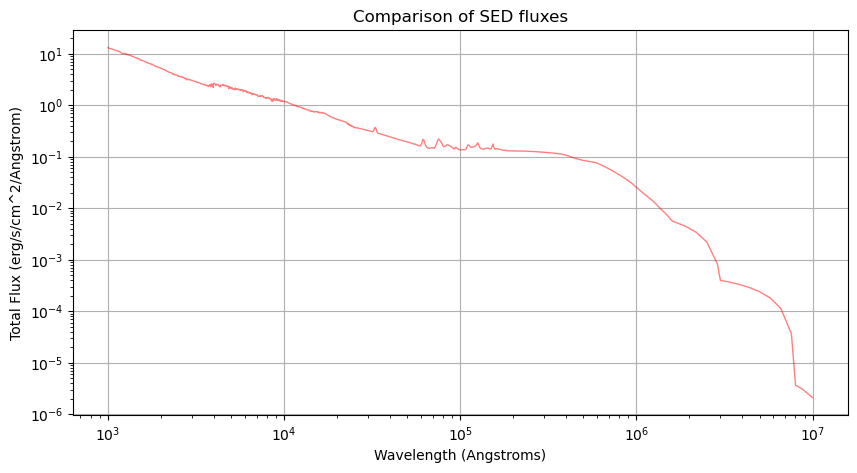

In [426]:
# We can now attempt to plot this
wl_comp = agn_starburst_composite_add['lambda (Angstroms)']
fl_comp = agn_starburst_composite_add['Total Flux (erg/s/cm^2/Angstrom)']

# Plotting the adjusted SEDS
plt.figure(figsize=(10, 5))
plt.loglog(wl_comp, fl_comp, color='red', linewidth=1, linestyle='-', alpha=0.5)
plt.xlabel('Wavelength (Angstroms)')
plt.ylabel('Total Flux (erg/s/cm^2/Angstrom)')
plt.title('Comparison of SED fluxes')
plt.grid()
plt.show()


In [427]:
# We attempt this method with multiple different values of alpha
alpha = np.linspace(0, 1, 6)

In [428]:
alpha

array([0. , 0.2, 0.4, 0.6, 0.8, 1. ])

Creating composite with alpha = 0.0
Creating composite with alpha = 0.2
Creating composite with alpha = 0.4
Creating composite with alpha = 0.6000000000000001
Creating composite with alpha = 0.8
Creating composite with alpha = 1.0


Text(0, 0.5, 'Total Flux (erg/s/cm^2/Angstrom)')

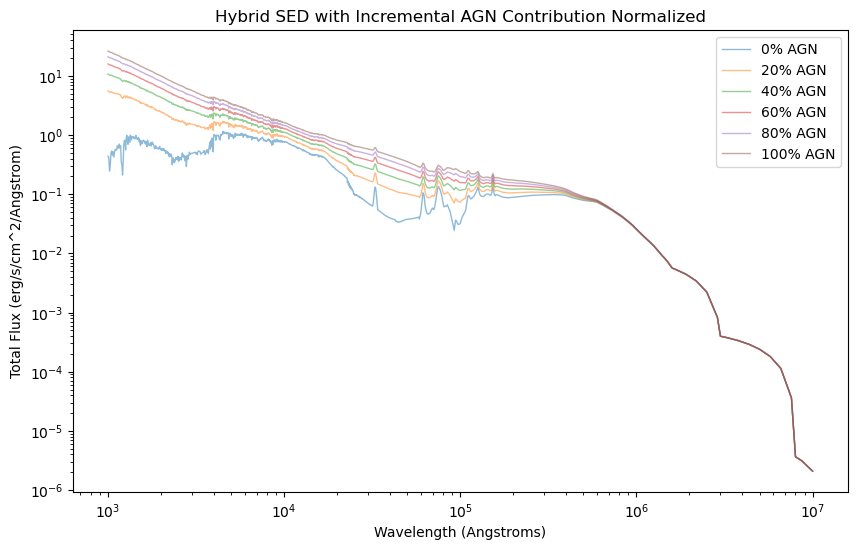

In [429]:
# Creating many composites
composites = []
for a in alpha:
    print(f'Creating composite with alpha = {a}')
    composite_galaxy = create_gal_agn_composite_sed(agn_model, m82_template, a, 1)
    composites.append(composite_galaxy)

# Plotting the adjusted SEDS
plt.figure(figsize=(10, 6))
for i, comp in enumerate(composites):
    wl_comp = comp['lambda (Angstroms)']
    fl_comp = comp['Total Flux (erg/s/cm^2/Angstrom)']
    plt.loglog(wl_comp, fl_comp, linewidth=1, linestyle='-', alpha=0.5, label=f'{round(alpha[i]*100)}% AGN')
plt.legend()
plt.title("Hybrid SED with Incremental AGN Contribution Normalized")
plt.xlabel('Wavelength (Angstroms)')
plt.ylabel('Total Flux (erg/s/cm^2/Angstrom)')

In [430]:
# Now we have a list of composite SEDs we can attempt to convert these into restframe UVJ colours and ultimately plot these on a UVJ diagram
colour_list = []
uv_list = []
vj_list = []



for n in range(6):
    
    # use the wavelength and flux of the sed
    wl = composites[n].iloc[:, 0].values
    fl = composites[n].iloc[:, 1].values
    

    # create an SED object containing the SED of the galaxy
    # in addition to this use the relevant wavelength and flux
    sed = astSED.SED(wavelength=wl, flux=fl) # z = 0.0 as these are restframe SEDs

    # Using the astSED library calculate the UVJ colours using the U, V, and J passbands. 
    # We will use the AB magnitude system
    uv = astSED.SED.calcColour(sed, pb_U, pb_V, magType='AB')
    vj = astSED.SED.calcColour(sed, pb_V, pb_J, magType='AB')
    
    uv_list.append(uv)
    vj_list.append(vj)

In [431]:
alpha


array([0. , 0.2, 0.4, 0.6, 0.8, 1. ])

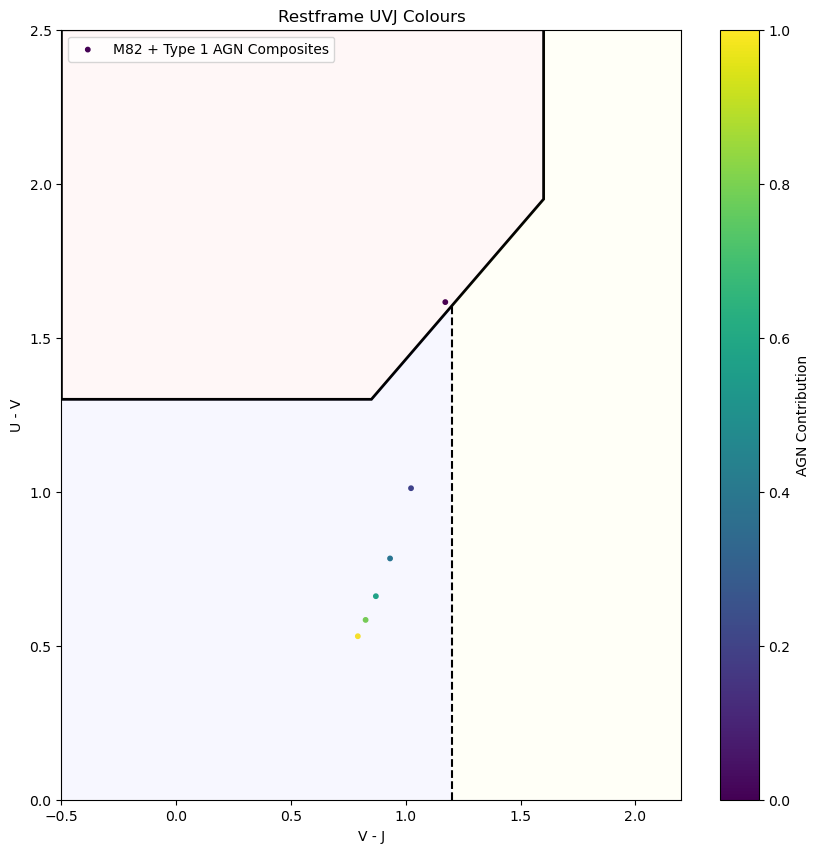

In [432]:
uv_colours = uv_list
vj_colours = vj_list
col = 'r'

plt.figure(figsize=(10, 10))
plt.scatter(vj_colours, uv_colours, c=alpha, s=10, label="M82 + Type 1 AGN Composites")
plt.ylabel('U - V')
plt.xlabel('V - J')
plt.title("Restframe UVJ Colours")
plt.xlim([-0.5, 2.2])
plt.ylim([0, 2.5])

# Set colourbar label
plt.colorbar().set_label('AGN Contribution')


# Define paths for selections
path_quiescent = [[-0.5, 1.3], [0.85, 1.3], [1.6, 1.95], [1.6, 2.5], [-0.5, 2.5]]
path_sf = [[-0.5, 0.0], [-0.5, 1.3], [0.85, 1.3], [1.2, 1.60333], [1.2, 0.0]]
path_sfd = [[1.2, 0.0], [1.2, 1.60333], [1.6, 1.95], [1.6, 2.5], [2.2, 2.5], [2.2, 0.0]]

# Add patches for selections
plt.gca().add_patch(plt.Polygon(path_quiescent, closed=True, fill=True, facecolor=(1, 0, 0, 0.03), edgecolor='k', linewidth=2, linestyle='solid'))
plt.gca().add_patch(plt.Polygon(path_sf, closed=True, fill=True, facecolor=(0, 0, 1, 0.03)))
plt.gca().add_patch(plt.Polygon(path_sfd, closed=True, fill=True, facecolor=(1, 1, 0, 0.03)))

# Add vertical line
plt.axvline(1.2, color='black', linestyle='--', ymin=0, ymax=1.60333/2.5)

plt.legend()
#Add text labels from name_list
#print(name_list[0])

plt.show()

In [433]:
# Again we can attempt to create a composite using a different galaxy templates.

# Now that we have a proof of concept that this works for one galaxy, we can generalise this and work with multiple galaxies
# Read in a list of swire tempaltes, and append them into a list
# Read in the subset of the swire templates


In [454]:
# To extend this we are now dealing with more than one galaxy so we need to make sure our code is flexible enough to be able to create
# useful composites that are correctly scaled. To do this we need to make sure every composite we generate is scaled accurately against a useful

# Follow a similar proccess as before

# Define the particular AGN Model we are exploring
# # 1. Type 1 AGN
tau = SKIRTOR_PARAMS['tau'][3]
p = SKIRTOR_PARAMS['p'][0]
q = SKIRTOR_PARAMS['q'][0]
oa = SKIRTOR_PARAMS['oa'][4]
rr = SKIRTOR_PARAMS['rr'][2]
i = SKIRTOR_PARAMS['i'][0]

agn_model = read_skirtor_model(skirtor_folderpath, tau, p, q, oa, rr, i)



# 2. Swire Templates
swire_templates = []
objname_list = []

# In this template set we have 3 ellipticals, 4 spirals, 2 star bursts, and a Seyfert 2 galaxy (which inherently has AGN contributions)
template_names = ['Ell2', 'Ell5', 'S0', 'Sb', 'Sc', 'M82', 'N6090', 'Sdm', 'Sey2']
for name in template_names:
    template, obj_name = read_swire_template(swire_folderpath, name)
    swire_templates.append(template)
    objname_list.append(obj_name)
    
    
# Make sure all galaxies are within the same wavelength range
for i, template in enumerate(swire_templates):
    
    swire_templates[i], agn_model = adjust_wavelength_range(template, agn_model)
    
    
# Utilize the function to create a set of composite galaxies for each of the swire templates with varying AGN contributions
alpha = np.linspace(0, 1, 11)
alpha # 11 different values of alpha, corresponding to 11 different composites for each of the swire


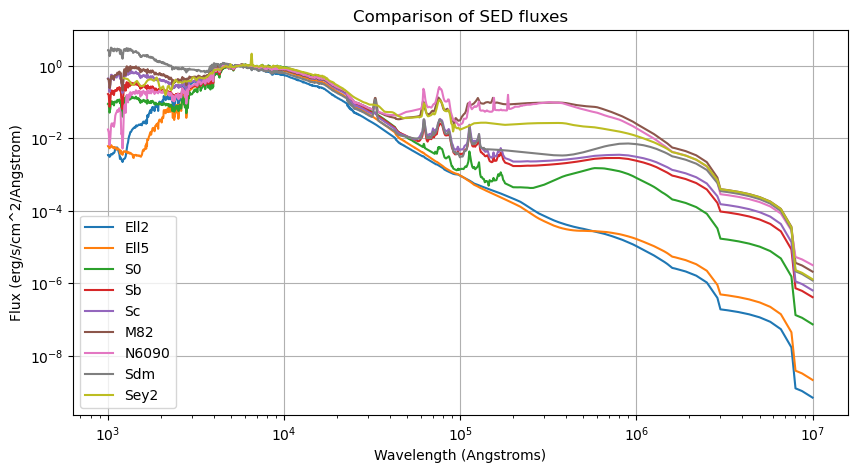

In [458]:

# Plot all the template on the same graph to ensure they are within the same wavelength range
plt.figure(figsize=(10, 5))
for i, template in enumerate(swire_templates):
    wl = template['lambda (Angstroms)']
    fl = template['Total Flux (erg/s/cm^2/Angstrom)']
    plt.loglog(wl, fl, label=objname_list[i])
#plt.loglog(wl_type2, fl_type2, label='Type 2 AGN', color='black', linestyle='--')
plt.xlabel('Wavelength (Angstroms)')
plt.ylabel('Flux (erg/s/cm^2/Angstrom)')
plt.title('Comparison of SED fluxes (SWIRE TEMPLATES)')
plt.grid()
plt.legend()




M82
Creating composite with alpha = 0.0
Creating composite with alpha = 0.1
Creating composite with alpha = 0.2
Creating composite with alpha = 0.30000000000000004
Creating composite with alpha = 0.4
Creating composite with alpha = 0.5
Creating composite with alpha = 0.6000000000000001
Creating composite with alpha = 0.7000000000000001
Creating composite with alpha = 0.8
Creating composite with alpha = 0.9
Creating composite with alpha = 1.0


Text(0, 0.5, 'Total Flux (erg/s/cm^2/Angstrom)')

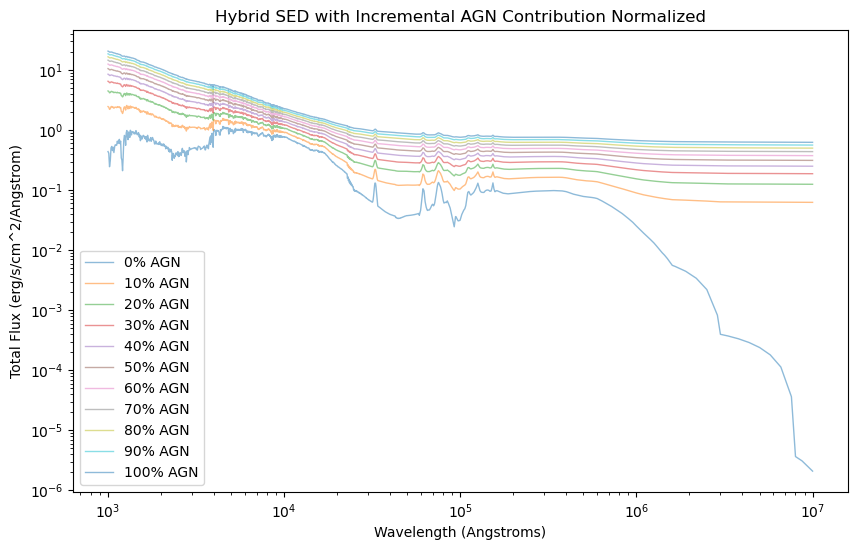

In [457]:
# We can now explore the creation of composites for each of the swire templates
# composite_list = []
# type_1_agn = agn_model
# for i, template in enumerate(swire_templates):
#     print(f'Creating composites for {objname_list[i]}')
#     composites = []
#     for a in alpha:
#         composite_galaxy = create_gal_agn_composite_sed(type_1_agn, template, a)
#         composites.append(composite_galaxy)
#         type_1_agn = agn_model
#     composite_list.append(composites)
i = 5
template = swire_templates[i]
print(objname_list[i])
# Creating many composites
composites = []
for a in alpha:
    
    print(f'Creating composite with alpha = {a}')
    composite_galaxy = create_gal_agn_composite_sed(agn_model, template, a, 1)
    composites.append(composite_galaxy)

# Plotting the adjusted SEDS
plt.figure(figsize=(10, 6))
for i, comp in enumerate(composites):
    wl_comp = comp['lambda (Angstroms)']
    fl_comp = comp['Total Flux (erg/s/cm^2/Angstrom)']
    plt.loglog(wl_comp, fl_comp, linewidth=1, linestyle='-', alpha=0.5, label=f'{round(alpha[i]*100)}% AGN')
plt.legend()
plt.title("Hybrid SED with Incremental AGN Contribution Normalized")
plt.xlabel('Wavelength (Angstroms)')
plt.ylabel('Total Flux (erg/s/cm^2/Angstrom)')


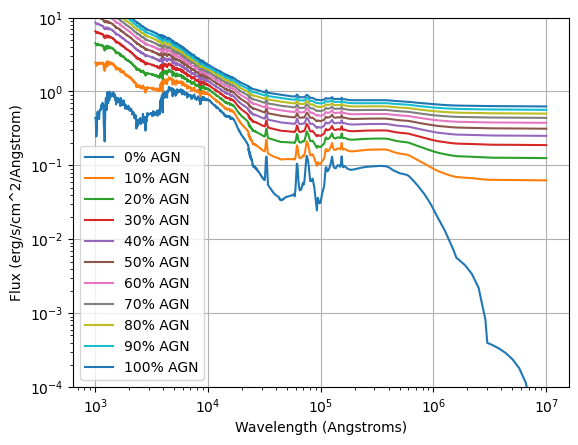

In [437]:
# Create a subplot for each of the set of composites, i.e for each of the SWIRE templates
# plot a subplot, with the varying percentages
#plt.figure(figsize=(20, 20))
# for i, composites in enumerate(composite_list):
#     plt.subplot(3, 3, i+1)
#     for n in range(11):
#         wl = composites[n].iloc[:, 0].values
#         fl = composites[n].iloc[:, 1].values
#         plt.loglog(wl, fl, label=f'{round(alpha[n]*100)}% AGN')
#     plt.xlabel('Wavelength (Angstroms)')
#     plt.ylabel('Flux (erg/s/cm^2/Angstrom)')
#     plt.title(f'{objname_list[i]}')
#     plt.grid()
#     plt.legend()
m = 6
for n in range(11):
    wl = composite_list[m][n].iloc[:, 0].values
    fl = composite_list[m][n].iloc[:, 1].values
    plt.loglog(wl, fl, label=f'{round(alpha[n]*100)}% AGN')
plt.xlabel('Wavelength (Angstroms)')
plt.ylabel('Flux (erg/s/cm^2/Angstrom)')
#plt.title(f'{objname_list[i]}')
plt.grid()
plt.ylim([10**(-4), 10**1])
plt.legend()



In [438]:
# Now we must convert these composites into UVJ colours
uv_list = []
vj_list = []

for i, composites in enumerate(composite_list):
    uv_colours = []
    vj_colours = []
    for n in range(11):
        wl = composites[n].iloc[:, 0].values
        fl = composites[n].iloc[:, 1].values
        sed = astSED.SED(wavelength=wl, flux=fl)
        uv = astSED.SED.calcColour(sed, pb_U, pb_V, magType='AB')
        vj = astSED.SED.calcColour(sed, pb_V, pb_J, magType='AB')
        uv_colours.append(uv)
        vj_colours.append(vj)
    uv_list.append(uv_colours)
    vj_list.append(vj_colours)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


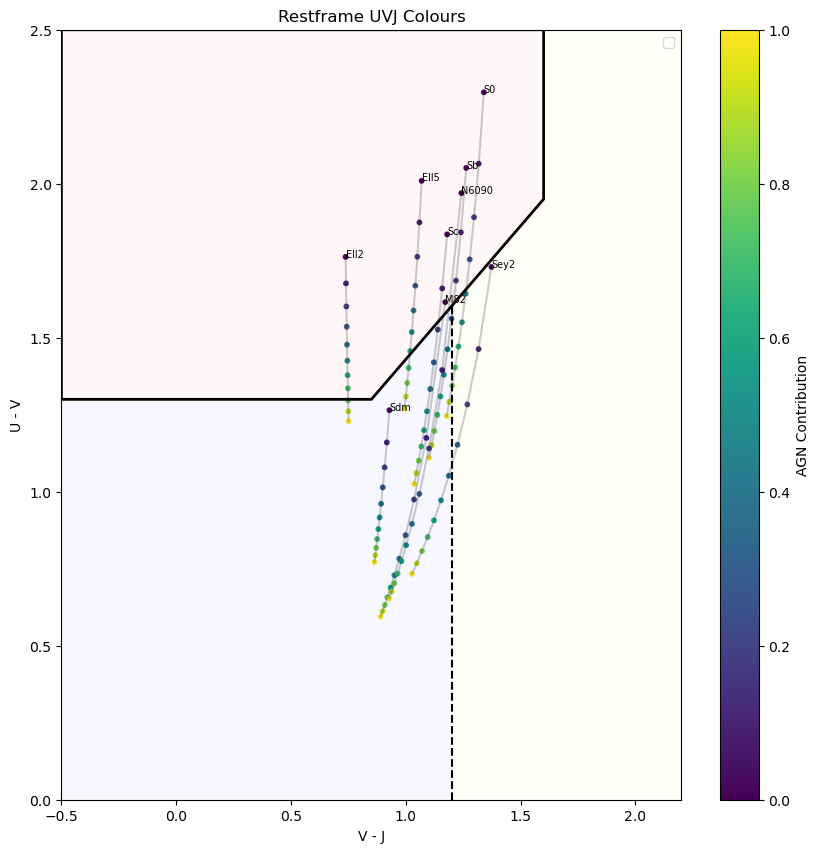

In [439]:
# Finally plotting these colours
plt.figure(figsize=(10, 10))
for i, uv in enumerate(uv_list):
    plt.scatter(vj_list[i], uv, c=alpha, s=10)
    # Plotting a connecting line between the points
    plt.plot(vj_list[i], uv, color='black', alpha=0.2)
plt.ylabel('U - V')
plt.xlabel('V - J')
plt.title("Restframe UVJ Colours")
plt.xlim([-0.5, 2.2])
plt.ylim([0, 2.5])
plt.colorbar().set_label('AGN Contribution')

# Define paths for selections
path_quiescent = [[-0.5, 1.3], [0.85, 1.3], [1.6, 1.95], [1.6, 2.5], [-0.5, 2.5]]
path_sf = [[-0.5, 0.0], [-0.5, 1.3], [0.85, 1.3], [1.2, 1.60333], [1.2, 0.0]]
path_sfd = [[1.2, 0.0], [1.2, 1.60333], [1.6, 1.95], [1.6, 2.5], [2.2, 2.5], [2.2, 0.0]]

# Add patches for selections
plt.gca().add_patch(plt.Polygon(path_quiescent, closed=True, fill=True, facecolor=(1, 0, 0, 0.03), edgecolor='k', linewidth=2, linestyle='solid'))
plt.gca().add_patch(plt.Polygon(path_sf, closed=True, fill=True, facecolor=(0, 0, 1, 0.03)))
plt.gca().add_patch(plt.Polygon(path_sfd, closed=True, fill=True, facecolor=(1, 1, 0, 0.03)))

# Add vertical line
plt.axvline(1.2, color='black', linestyle='--', ymin=0, ymax=1.60333/2.5)

# Create a lebl for the first entry of each list: i.e where the AGN contribution is 0 for each of the SWIRE tempaltes
for i, obj in enumerate(objname_list):
    # Making sure the font is readable and a good colour
    plt.text(vj_list[i][0], uv_list[i][0], obj, fontsize=7)



plt.legend()
plt.show()


In [440]:
#Using this proccess we can similarly create composites for type 2 AGN, and then a resulting intermediate type agn
# 2. Type 2 AGN
tau = SKIRTOR_PARAMS['tau'][3]
p = SKIRTOR_PARAMS['p'][0]
q = SKIRTOR_PARAMS['q'][1]
oa = SKIRTOR_PARAMS['oa'][4]
rr = SKIRTOR_PARAMS['rr'][2]
i = SKIRTOR_PARAMS['i'][9]

type2_agn_model = read_skirtor_model(skirtor_folderpath, tau, p, q, oa, rr, i)


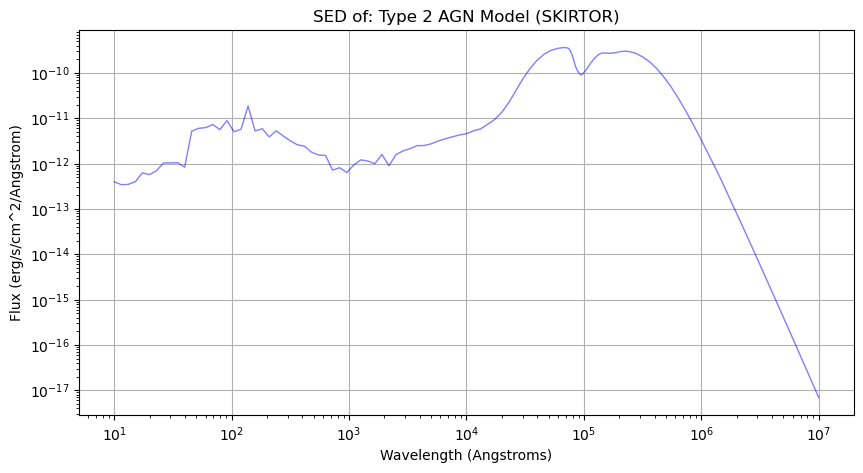

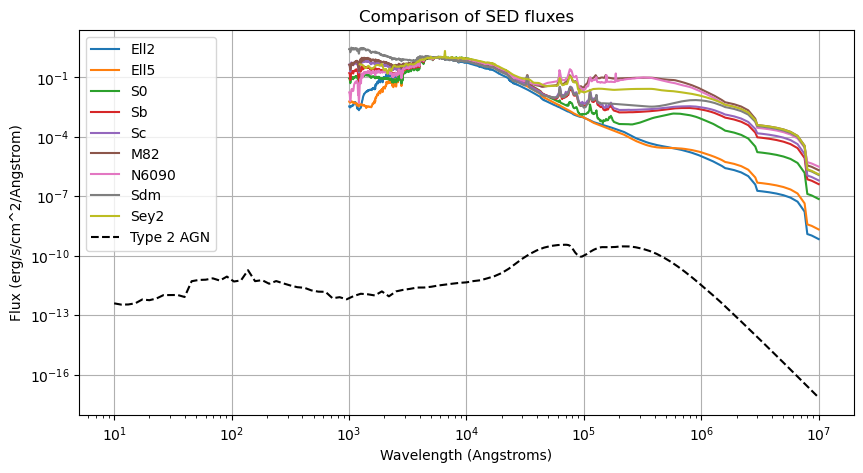

In [441]:

# We would like to plot the SEDs for this model
wl_type2 = type2_agn_model['lambda (Angstroms)']
fl_type2 = type2_agn_model['Total Flux (erg/s/cm^2/Angstrom)']

# Plot the SED of the type 2 AGN
plot_galaxy_sed(wl_type2, fl_type2, "Type 2 AGN Model", "SKIRTOR")


# We would also like to plot the SEDs of all of the SWIRE models on one diagram
plt.figure(figsize=(10, 5))
for i, template in enumerate(swire_templates):
    wl = template['lambda (Angstroms)']
    fl = template['Total Flux (erg/s/cm^2/Angstrom)']
    plt.loglog(wl, fl, label=objname_list[i])
plt.loglog(wl_type2, fl_type2, label='Type 2 AGN', color='black', linestyle='--')
plt.xlabel('Wavelength (Angstroms)')
plt.ylabel('Flux (erg/s/cm^2/Angstrom)')
plt.title('Comparison of SED fluxes')
plt.grid()
plt.legend()




Text(0.5, 1.0, 'Comparison of SED fluxes')

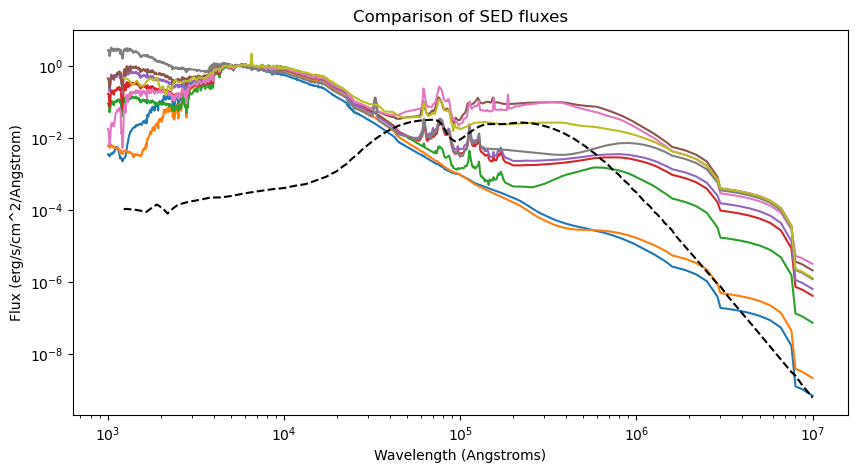

In [442]:
# After adjusting the wavelength range 
for i, template in enumerate(swire_templates):
    swire_templates[i], type2_agn_model = adjust_wavelength_range(template, type2_agn_model)
   
# Before any composites are created we need to make sure we scale the AGN model to the same flux as the SWIRE templates, 
# this is done by generating a scaling factor for the AGN model, and multiplying that by the value 
# of the int_galaxy/int_agn * agn flux
scaling_factor = compute_scaling_factor(type2_agn_model, swire_templates[0]) 
 
# We can now attempt to replot these both on the same graph
plt.figure(figsize=(10, 5))
for i, template in enumerate(swire_templates):
    wl = template['lambda (Angstroms)']
    fl = template['Total Flux (erg/s/cm^2/Angstrom)']
    plt.loglog(wl, fl, label=objname_list[i])
wl_type2 = type2_agn_model['lambda (Angstroms)']
fl_type2 = type2_agn_model['Total Flux (erg/s/cm^2/Angstrom)']*scaling_factor
plt.loglog(wl_type2, fl_type2, label='Type 2 AGN', color='black', linestyle='--')
plt.xlabel('Wavelength (Angstroms)')
plt.ylabel('Flux (erg/s/cm^2/Angstrom)')
plt.title('Comparison of SED fluxes')


In [443]:
# We can now explore fully creating the Galaxy+AGN composites for the type 2 AGN model
alpha = np.linspace(0, 1, 11)
# We can now explore the creation of composites for each of the swire templates
composite_list = []
for i, template in enumerate(swire_templates):
    print(f'Creating composites for {objname_list[i]}')
    composites = []
    for a in alpha:
        composite_galaxy = create_gal_agn_composite_sed(type2_agn_model, template, a)
        composites.append(composite_galaxy)
    composite_list.append(composites)


# # Plot the SEDS for each of the composites, with the varying AGN contributions
# plt.figure(figsize=(10, 5))
# for i, composites in enumerate(composite_list):
#     for n in range(11):
#         wl = composites[n].iloc[:, 0].values
#         fl = composites[n].iloc[:, 1].values
#         plt.loglog(wl, fl, label=f'{objname_list[i]} {round(alpha[n]*100)}% AGN')
# plt.xlabel('Wavelength (Angstroms)')
# plt.ylabel('Flux (erg/s/cm^2/Angstrom)')
# plt.title('Comparison of SED fluxes')
# plt.grid()
# plt.legend()



Creating composites for Ell2
Creating composites for Ell5
Creating composites for S0
Creating composites for Sb
Creating composites for Sc
Creating composites for M82
Creating composites for N6090
Creating composites for Sdm
Creating composites for Sey2


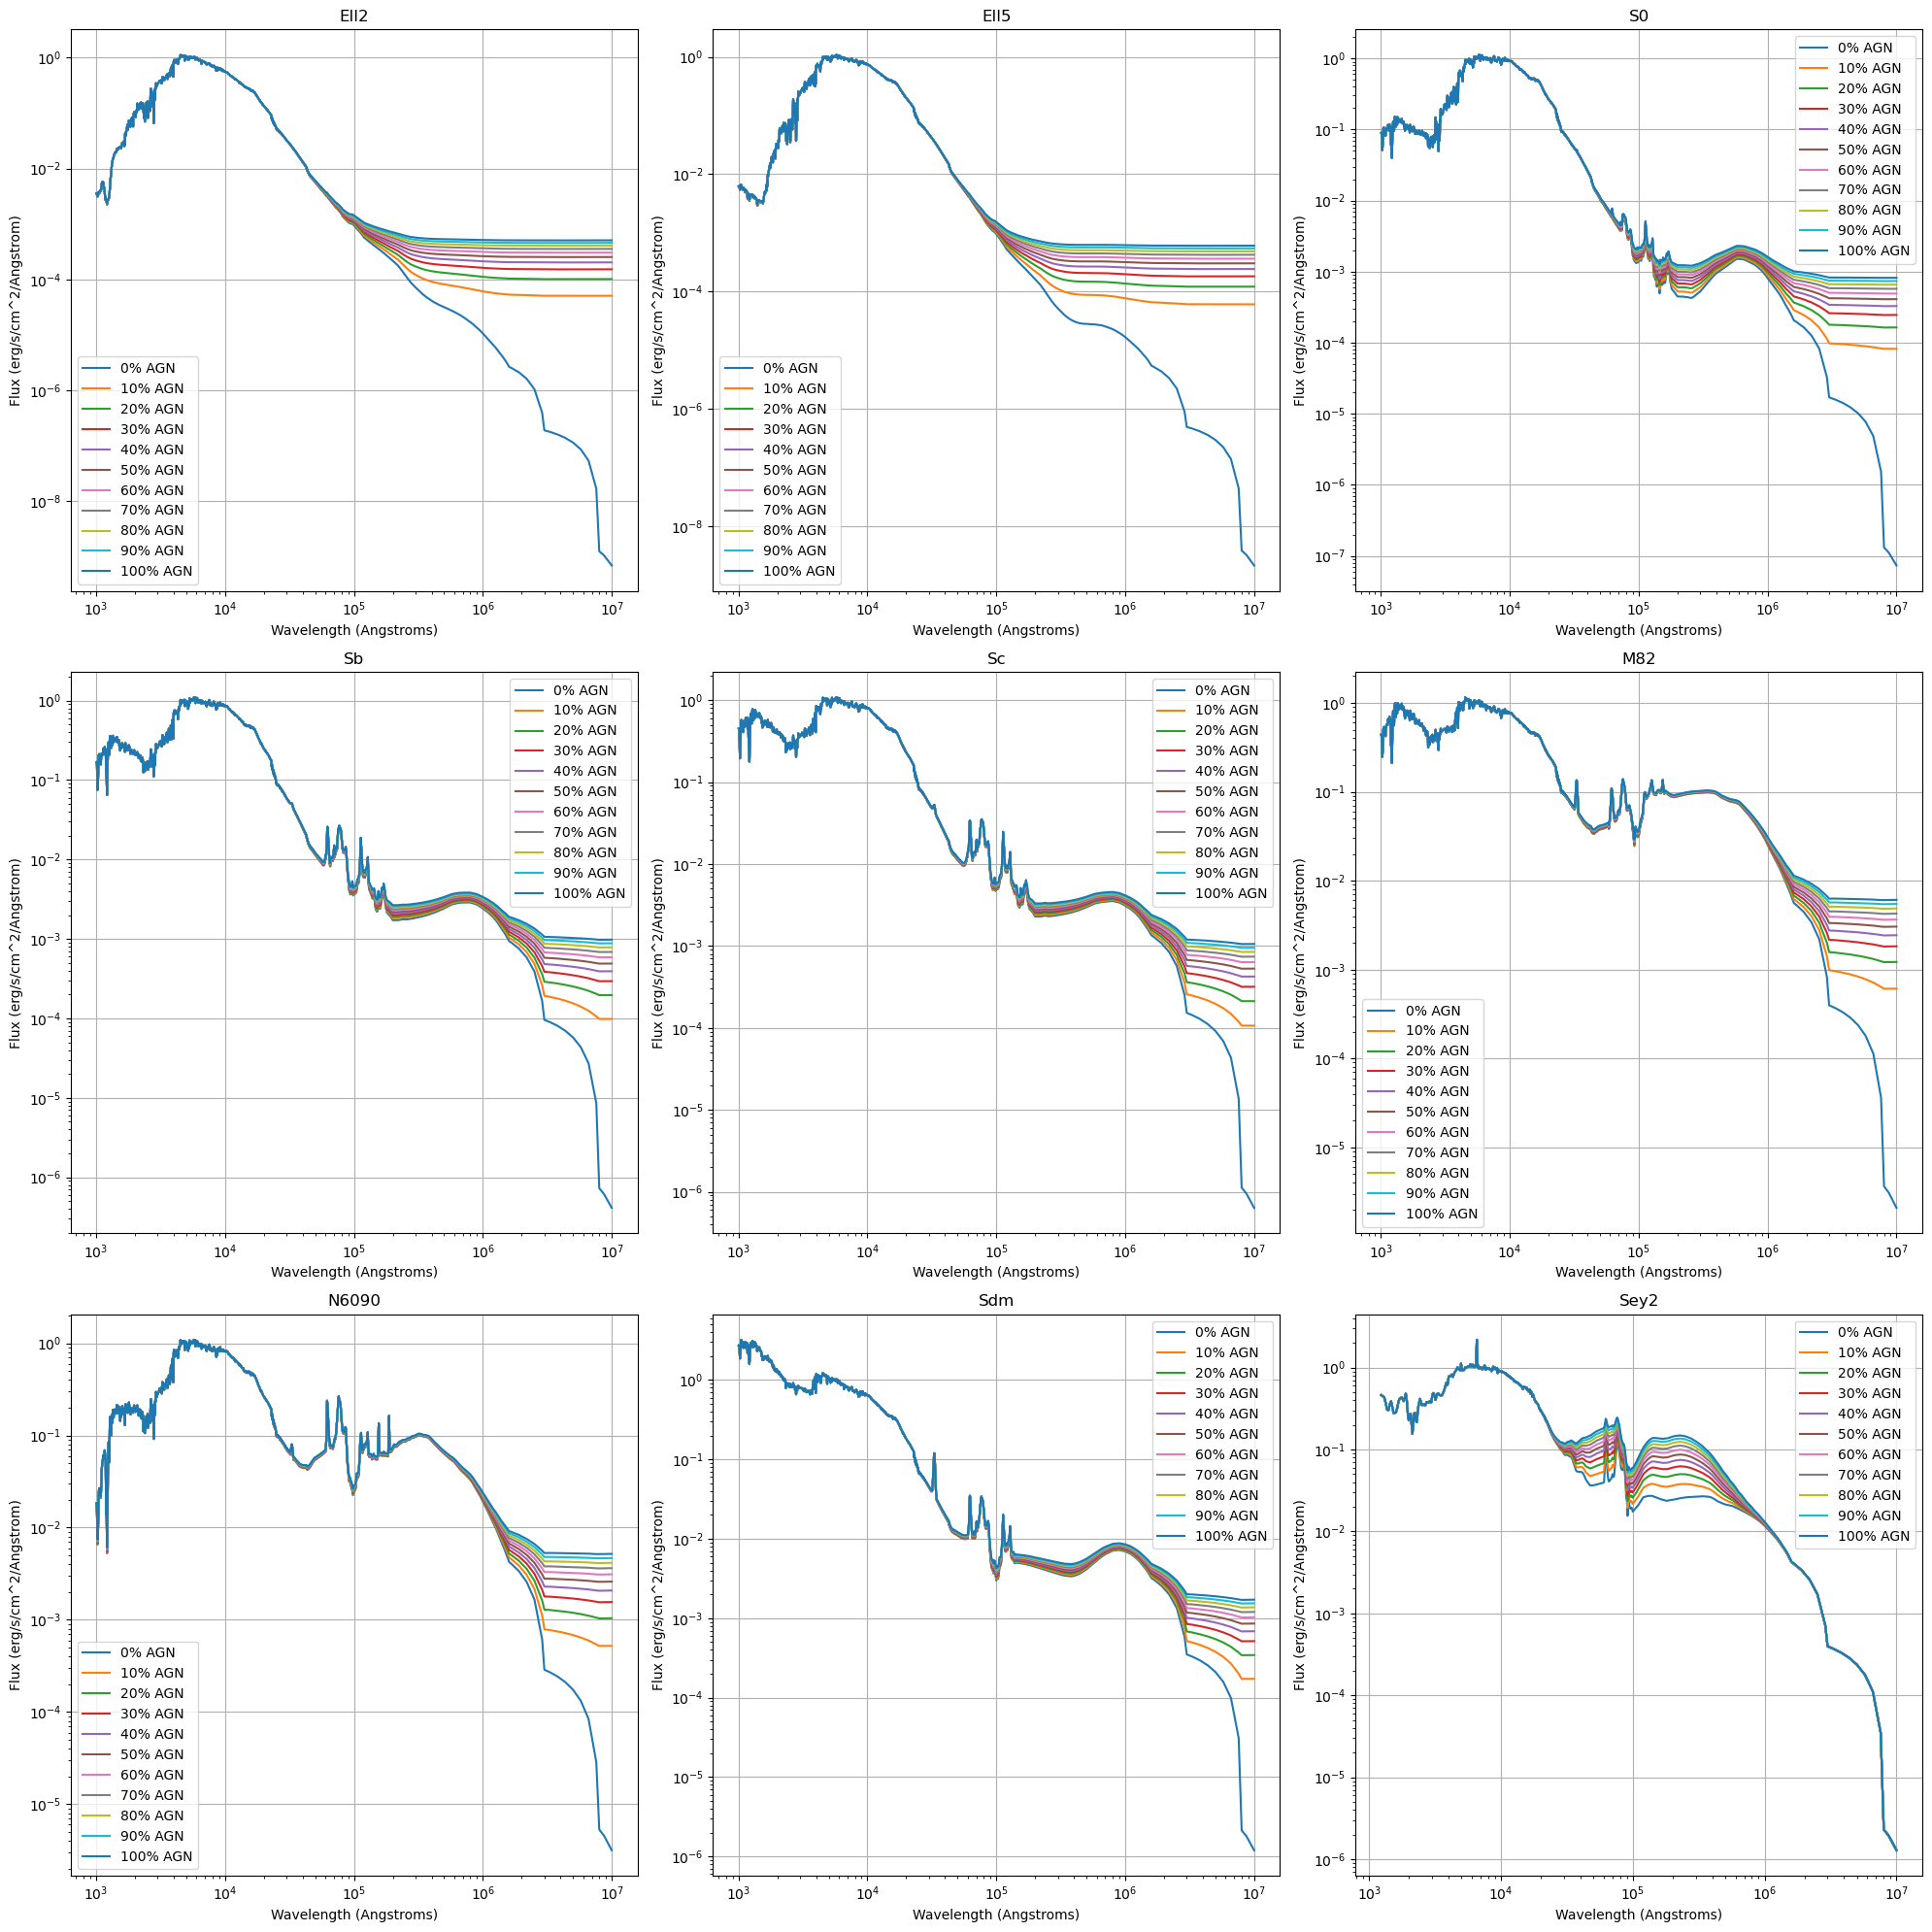

In [444]:
# Create a subplot for each of the set of composites, i.e for each of the SWIRE templates
# plot a subplot, with the varying percentages
plt.figure(figsize=(20, 20))
for i, composites in enumerate(composite_list):
    plt.subplot(3, 3, i+1)
    for n in range(11):
        wl = composites[n].iloc[:, 0].values
        fl = composites[n].iloc[:, 1].values
        plt.loglog(wl, fl, label=f'{round(alpha[n]*100)}% AGN')
    plt.xlabel('Wavelength (Angstroms)')
    plt.ylabel('Flux (erg/s/cm^2/Angstrom)')
    plt.title(f'{objname_list[i]}')
    plt.grid()
    plt.legend()
plt.tight_layout()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


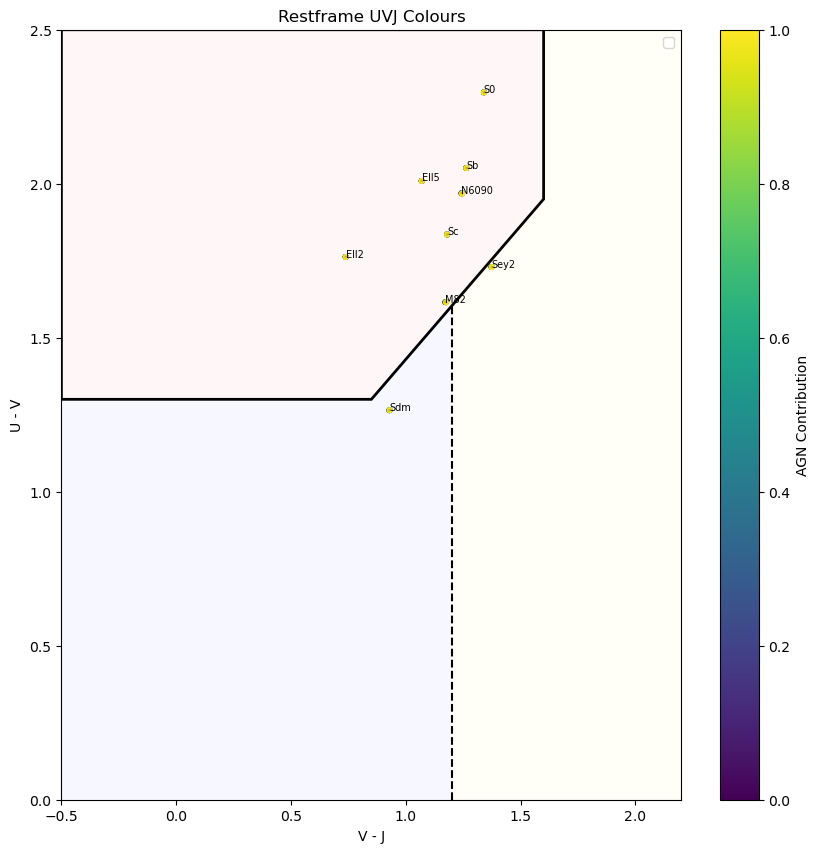

In [445]:
# Given our composites we can plot these on a UVJ diagram and explore the UVJ behaviour as before
# Now we must convert these composites into UVJ colours
uv_list = []
vj_list = []

for i, composites in enumerate(composite_list):
    uv_colours = []
    vj_colours = []
    for n in range(11):
        wl = composites[n].iloc[:, 0].values
        fl = composites[n].iloc[:, 1].values
        sed = astSED.SED(wavelength=wl, flux=fl)
        uv = astSED.SED.calcColour(sed, pb_U, pb_V, magType='AB')
        vj = astSED.SED.calcColour(sed, pb_V, pb_J, magType='AB')
        uv_colours.append(uv)
        vj_colours.append(vj)
    uv_list.append(uv_colours)
    vj_list.append(vj_colours)
    
# Using these UVJ colours we can plot these on a UVJ diagram
# Finally plotting these colours
plt.figure(figsize=(10, 10))
for i, uv in enumerate(uv_list):
    plt.scatter(vj_list[i], uv, c=alpha, s=10)
    # Plotting a connecting line between the points
    plt.plot(vj_list[i], uv, color='black', alpha=0.2)
plt.ylabel('U - V')
plt.xlabel('V - J')
plt.title("Restframe UVJ Colours")
plt.xlim([-0.5, 2.2])
plt.ylim([0, 2.5])
plt.colorbar().set_label('AGN Contribution')

# Define paths for selections
path_quiescent = [[-0.5, 1.3], [0.85, 1.3], [1.6, 1.95], [1.6, 2.5], [-0.5, 2.5]]
path_sf = [[-0.5, 0.0], [-0.5, 1.3], [0.85, 1.3], [1.2, 1.60333], [1.2, 0.0]]
path_sfd = [[1.2, 0.0], [1.2, 1.60333], [1.6, 1.95], [1.6, 2.5], [2.2, 2.5], [2.2, 0.0]]

# Add patches for selections
plt.gca().add_patch(plt.Polygon(path_quiescent, closed=True, fill=True, facecolor=(1, 0, 0, 0.03), edgecolor='k', linewidth=2, linestyle='solid'))
plt.gca().add_patch(plt.Polygon(path_sf, closed=True, fill=True, facecolor=(0, 0, 1, 0.03)))
plt.gca().add_patch(plt.Polygon(path_sfd, closed=True, fill=True, facecolor=(1, 1, 0, 0.03)))

# Add vertical line
plt.axvline(1.2, color='black', linestyle='--', ymin=0, ymax=1.60333/2.5)

# Create a lebl for the first entry of each list: i.e where the AGN contribution is 0 for each of the SWIRE tempaltes
for i, obj in enumerate(objname_list):
    # Making sure the font is readable and a good colour
    plt.text(vj_list[i][0], uv_list[i][0], obj, fontsize=7)



plt.legend()
plt.show()